In [1]:
# humei1, 2の方の名前を要確認

# 趣旨: 機械学習を用い、画像内の人物判定を行う。
# 回帰や次元削減、グラフ描画、他アルゴリズム等、ちょうどいいテーマが見つかり次第、また新しく作ります。
# 元の画像枚数が7枚しかないので、NumPy Data Augmentationで画像データを水増ししています。

# 教師あり学習: k近傍法(k-NN)、サポートベクタマシン、ランダムフォレスト、グリッドサーチでそれぞれ試してみました。
# 教師なし学習: ついでにKMeansによるクラスタリングもやってみました。

# 今回行ったものの中ではランダムフォレスト, グリッドサーチバージョンが一番正解率が高めでした。
# （元画像素材7枚 → 水増しからの正解率95%越え）


# ↓ 途中までは共用 ↓


switch = 0 # 0で全画像を使用、1でグレー画像のみ使用、2でいくつか削ったもの、以外はgrayscale画像などを作成


import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

%matplotlib inline


# NumPy Data Augmentation用関数
# Horizontal Flip
def horizontal_flip(image, rate = 1):
    if np.random.rand() < rate:
        image = image[:, ::-1, :]
    return image

# Vertical Flip
def vertical_flip(image, rate = 1):
    if np.random.rand() < rate:
        image = image[::-1, :, :]
    return image

# Random Rotation
from scipy.ndimage.interpolation import rotate
def random_rotation(image, angle_range = (0, 180)):
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
#    image = imresize(image, (h, w))
    return image

元画像の枚数: 7
.csvの中身（教師データ内訳）: 
    id  ookawa  aikawa  huse  abe  nakazawa  sawada  satou  humei1  humei2
0    0       1       0     0    0         0       0      0       0       0
1    1       1       0     0    0         0       0      0       0       0
2    2       1       0     0    0         0       0      0       0       0
3    3       1       0     0    0         0       0      0       0       0
4    4       1       0     0    0         0       0      0       0       0
5    5       1       0     0    0         0       0      0       0       0
6    6       1       0     0    0         0       0      0       0       0
7    7       0       0     0    0         0       1      1       0       0
8    8       0       0     0    0         0       1      1       0       0
9    9       0       0     0    0         0       1      1       0       0
10  10       0       0     0    0         0       1      1       0       0
11  11       0       0     0    0         0       1      1       0     

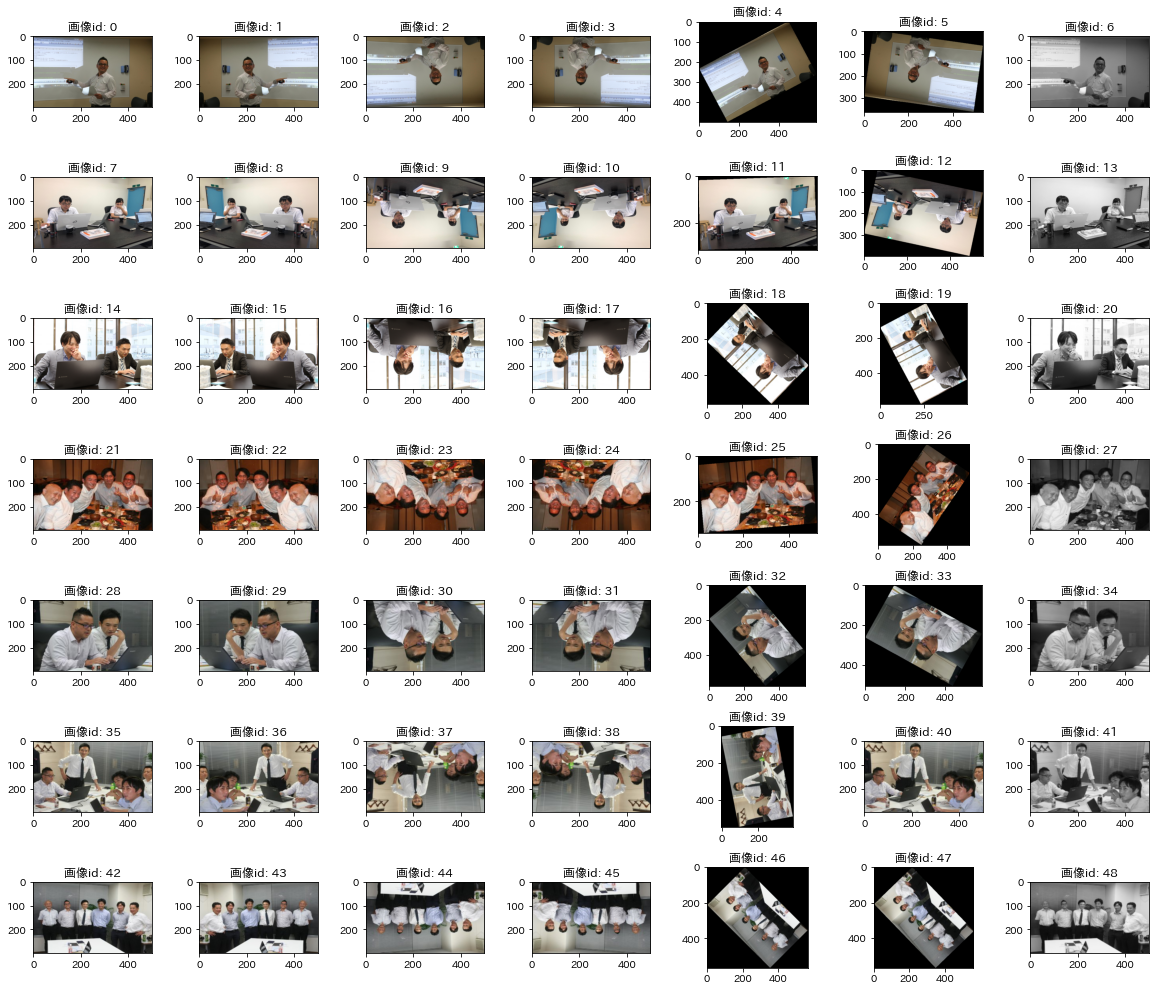

In [2]:
# 教師データ.csv読み込み
file_name = ""
csv_rows_num = 0
if switch == 0:
    file_name = "./images/member_classified.csv" # 全画像ver
    csv_rows_num = sum([1 for _ in open(file_name)]) // 7
elif switch == 1:
    file_name = "./images/member_classified_gray.csv" # グレーのみver
    csv_rows_num = sum([1 for _ in open(file_name)]) // 6
elif switch == 2:
    file_name = "./images/member_classified_shaved.csv" # いくつか削ったver
    csv_rows_num = sum([1 for _ in open(file_name)]) // 4

targets_data = pd.read_csv(file_name)


print("元画像の枚数: " + str(csv_rows_num))
print(".csvの中身（教師データ内訳）: ")
print(targets_data)


# 登場人物のリスト
target_person = [value for value in targets_data]
target_person = target_person[1:]
print("登場人物のリスト: " + str(target_person))


# 機械学習での判定に使う画像を加工しながら配列に格納
# 元の画像材料が7枚のみ。40数枚に水増し
img_list = []
for i in range(csv_rows_num):
    if switch == 0:
        target_img = Image.open("./images/%03d.jpg" % (i))
        target_img = target_img.resize((500, 300))

        img_list.append(np.array(target_img))
        img_list.append(horizontal_flip(np.array(target_img)))
        img_list.append(vertical_flip(np.array(target_img)))    
        img_list.append(horizontal_flip(vertical_flip(np.array(target_img))))
        img_list.append(random_rotation(np.array(target_img)))
        img_list.append(random_rotation(np.array(target_img)))

        # ついでにグレースケールの画像も追加
        target_img = Image.open("./images/gray%03d.jpg" % (i))
        target_img = cv2.imread("./images/gray%03d.jpg" % (i), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.resize(target_img, (500, 300))
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB) # BGR → RGBに変換
        img_list.append(np.array(target_img))
        
    elif switch == 1:
        target_img = cv2.imread("./images/%03d.jpg" % (i), cv2.IMREAD_GRAYSCALE)
        target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB) # BGR → RGBに変換
        target_img = cv2.resize(target_img, (500, 300))

        img_list.append(target_img)
        img_list.append(horizontal_flip(target_img))
        img_list.append(vertical_flip(target_img))    
        img_list.append(horizontal_flip(target_img))
        img_list.append(random_rotation(target_img))
        img_list.append(random_rotation(target_img))

    elif switch == 2:
        target_img = Image.open("./images/%03d.jpg" % (i))
        target_img = target_img.resize((500, 300))

        img_list.append(np.array(target_img))
        img_list.append(horizontal_flip(np.array(target_img)))
        img_list.append(vertical_flip(np.array(target_img)))    
        img_list.append(horizontal_flip(vertical_flip(np.array(target_img))))

    else:
#        グレースケール画像などを作成するためのもの
        jpg = "./images/%03d.jpg" % (i)
        img = cv2.imread(jpg, cv2.IMREAD_GRAYSCALE)
        cv2.imwrite("./images/gray%03d.jpg" % (i), img)
        img = cv2.imread(jpg, cv2.IMREAD_UNCHANGED)
        cv2.imwrite("./images/rgba%03d.jpg" % (i), img)    

print("Augmentationで水増し処理後の画像の合計枚数: " + str(len(img_list)))

# 配列に格納した画像をサブプロットで描画し確認
def img__show_adj(w_size = 20, hsize = 15, w_num = 7, w_space = 0, h_space = 0):
    img_plot_fig = plt.figure(figsize = (w_size, w_size))
    for i in range(len(img_list)):
        img_plot = img_plot_fig.add_subplot((len(img_list) // w_num) + 1, w_num, i + 1)
        img_plot.set_title("画像id: " + str(i))
        plt.subplots_adjust(wspace = w_space, hspace = h_space)
        img_plot.imshow(img_list[i])

if switch == 0:
    img__show_adj(20, 20, 7, 0.4, 0.4)
elif switch == 1:
    img__show_adj(20, 20, 6, 0.4, 0.4)
elif switch == 2:
    img__show_adj(20, 20, 4, 0.4, 0.4)

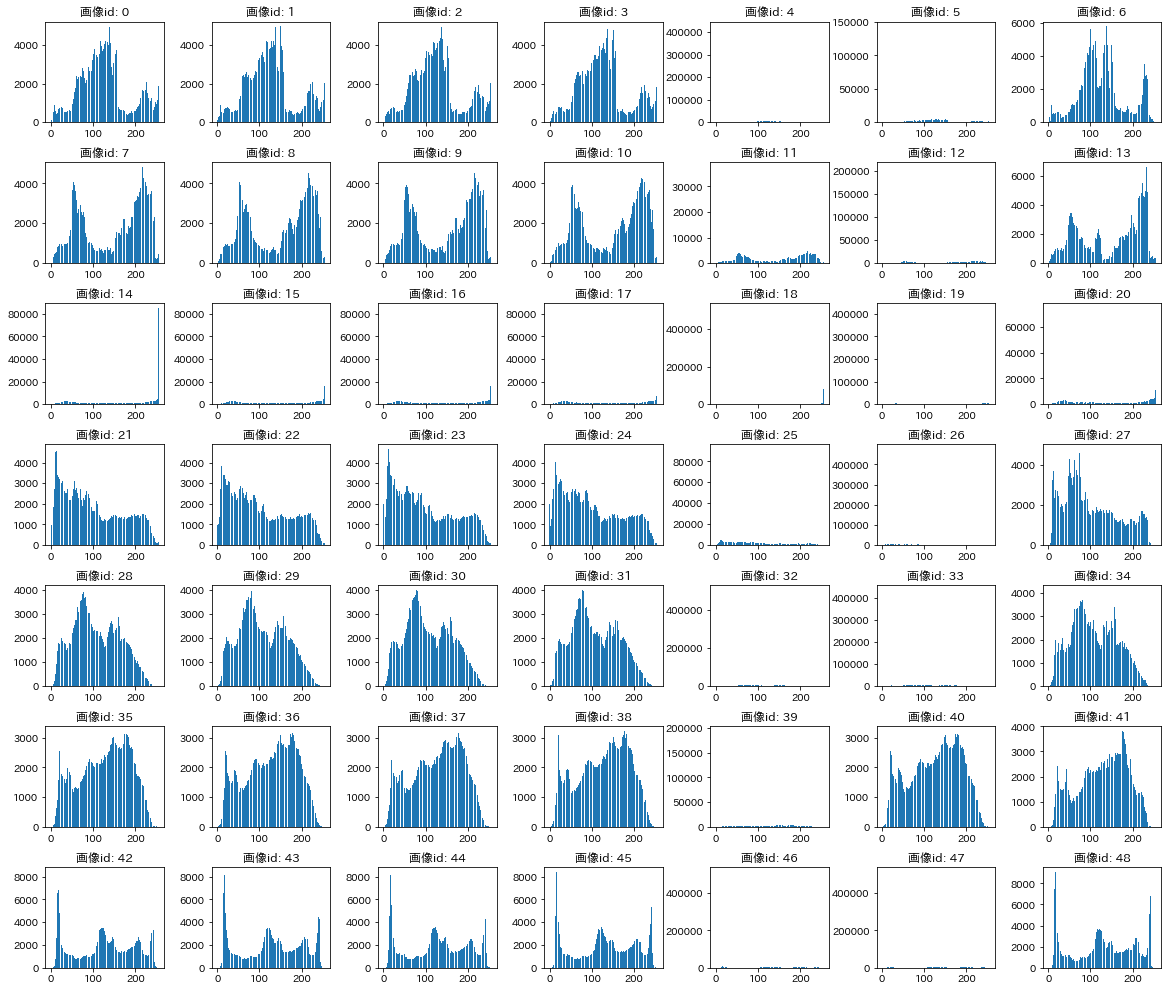

In [3]:
images_data = np.empty((0, 256), int)
# print(images_data.shape)

# ヒストグラムを特徴量として使用するため、配列に格納
for img in img_list:
    hist = np.histogram(img.ravel(), 256, [0, 256])
    img_hist = hist[0]
    images_data = np.append(images_data, np.array([hist[0]]), axis = 0)

    
# ヒストグラムを描画し確認
def plot_hist(w_size = 20, hsize = 15, w_num = 7, w_space = 0, h_space = 0):
    hist_plot_fig = plt.figure(figsize = (w_size, w_size))
    for i, img_hist in enumerate(images_data):
        hist_plot = hist_plot_fig.add_subplot((len(img_list) // w_num) + 1, w_num, i + 1)
        hist_plot.set_title("画像id: " + str(i))
        hist_plot.bar(np.arange(256), img_hist)
    else:
        plt.subplots_adjust(wspace = w_space, hspace = h_space)
        plt.show()

if switch == 0:
    plot_hist(20, 20, 7, 0.4, 0.4)
elif switch == 1:
    plot_hist(20, 20, 6, 0.4, 0.4)
elif switch == 2:
    plot_hist(20, 20, 4, 0.4, 0.4)
    

# jupyter Nootbook上で結果の表示を分けたかったため、各学習について一度それぞれを配列に格納し後から描画
check_list_1 = []
check_list_2 = []

# ↑ ここまでは共用 ↑

In [4]:
print("images_data.shape: ", images_data.shape)
print("targets_data['ookawa'].shape: ", targets_data['ookawa'].shape)
for line in images_data:
    print(line)

images_data.shape:  (49, 256)
targets_data['ookawa'].shape:  (49,)
[  15  107   62  267  204  306  528  423  889  593  519  556  597  414
  444  489  548  669  677  749  724  771  716  794  797  789  751  746
  779  663  629  546  516  578  519  531  503  535  574  605  684  577
  687  618  655  629  578  672  611  691  890  923 1026 1175 1361 1379
 1577 1729 1770 2045 2403 2237 2454 2222 2458 2347 2618 2483 2583 2600
 2396 2389 2324 2431 2450 2795 2743 2674 2665 2272 1966 2192 2026 2136
 2174 2494 2267 2383 2446 2856 2707 2643 2646 2575 2724 2566 2669 2634
 3206 3083 3316 3524 3700 3785 3196 3476 3472 3612 3464 3489 3379 3244
 3112 3265 3554 3505 3439 4213 3948 4164 3954 4116 3687 3748 3768 3843
 3822 4042 4122 4189 3766 3876 3576 4179 4134 4333 3981 4819 4904 4915
 4313 4072 3215 2837 2752 2653 2463 2846 3058 4237 4960 4792 3917 3541
 3343 3713 3696 2605 1351 1014  808  692  682  548  532  612  595  614
  580  551  589  610  651  668  580  530  561  462  445  415  444  383
  382  416

In [5]:
# ランダムフォレスト, グリッドサーチバージョン

'''
現状の結果
学習の種類: 教師あり学習
使用分類アルゴリズム: ランダムフォレスト, グリッドサーチ
seed値固定せずのランダム仕様

# カラー画像使用バージョン
テストデータ（画像） 13枚に対しての

ookawaさんの機械学習の判定正解率: 1.0
aikawaさんの機械学習の判定正解率: 1.0
huseさんの機械学習の判定正解率: 1.0
abeさんの機械学習の判定正解率: 1.0
nakazawaさんの機械学習の判定正解率: 1.0
sawadaさんの機械学習の判定正解率: 1.0
satouさんの機械学習の判定正解率: 1.0
humei1さんの機械学習の判定正解率: 0.9230769230769231
humei2さんの機械学習の判定正解率: 1.0

全体の平均正解率: 0.9914529914529915


# グレー画像使用バージョン
テストデータ（画像） 11枚に対しての

ookawaさんの機械学習の判定正解率: 0.7272727272727273
aikawaさんの機械学習の判定正解率: 1.0
huseさんの機械学習の判定正解率: 1.0
abeさんの機械学習の判定正解率: 1.0
nakazawaさんの機械学習の判定正解率: 1.0
sawadaさんの機械学習の判定正解率: 1.0
satouさんの機械学習の判定正解率: 1.0
humei1さんの機械学習の判定正解率: 1.0
humei2さんの機械学習の判定正解率: 1.0

全体の平均正解率: 0.9696969696969696

# 画像を削ったバージョン
テストデータ（画像） 7枚に対しての

ookawaさんの機械学習の判定正解率: 1.0
aikawaさんの機械学習の判定正解率: 1.0
huseさんの機械学習の判定正解率: 1.0
abeさんの機械学習の判定正解率: 1.0
nakazawaさんの機械学習の判定正解率: 1.0
sawadaさんの機械学習の判定正解率: 1.0
satouさんの機械学習の判定正解率: 1.0
humei1さんの機械学習の判定正解率: 1.0
humei2さんの機械学習の判定正解率: 1.0

全体の平均正解率: 1.0
'''

from sklearn.ensemble import RandomForestClassifier

# 学習 → 予測をさせ、結果を各配列に格納
for i, name in enumerate(target_person):
    print(name + "さん: ")

    X_train, X_test, y_train, y_test = train_test_split(images_data, targets_data[name])

    # ランダムフォレスト、グリッドサーチを使用
    param = {'n_estimators': np.arange(1, 150)}
    grid_search = GridSearchCV(RandomForestClassifier(), param, cv = 5, verbose = 3, n_jobs = -1) # cv = 5

    grid_search.fit(X_train,y_train)
    y_predict = grid_search.predict(X_test)

    if i == 0:
        check_list_2.append("テストデータ（画像） {}枚に対しての".format(str(len(X_test))))
    check_list_2.append(["{}さんの機械学習の判定正解率: ".format(target_person[i]), np.mean(y_predict == y_test)])

    for v, [j, k] in enumerate(y_test.items()): # 実際の正解と機械学習の判別値, 1 = いる 0 = いない
        print("index: ", v, " 画像id: ", j, " 正解: ", k, " 予測: ", y_predict[v])
    
    print("正解率: ", np.mean(y_predict == y_test), "\n")

    # classification_reportの表示
    # precision = 適合率, recall = 再現率, f1-score = F値（適合率と再現率の調和平均、バランス）, support = データ数
    print(classification_report(y_test, y_predict))

ookawaさん: 
Fitting 5 folds for each of 149 candidates, totalling 745 fits
index:  0  画像id:  22  正解:  1  予測:  1
index:  1  画像id:  37  正解:  1  予測:  1
index:  2  画像id:  10  正解:  0  予測:  0
index:  3  画像id:  30  正解:  1  予測:  1
index:  4  画像id:  18  正解:  0  予測:  0
index:  5  画像id:  20  正解:  0  予測:  1
index:  6  画像id:  44  正解:  1  予測:  1
index:  7  画像id:  3  正解:  1  予測:  1
index:  8  画像id:  34  正解:  1  予測:  1
index:  9  画像id:  35  正解:  1  予測:  1
index:  10  画像id:  26  正解:  1  予測:  1
index:  11  画像id:  43  正解:  1  予測:  1
index:  12  画像id:  25  正解:  1  予測:  1
正解率:  0.9230769230769231 

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.91      1.00      0.95        10

    accuracy                           0.92        13
   macro avg       0.95      0.83      0.88        13
weighted avg       0.93      0.92      0.92        13

aikawaさん: 
Fitting 5 folds for each of 149 candidates, totalling 745 fits
index:  0  画像id

c:\python_practice_storage\person_judgment\p_j\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python_practice_storage\person_judgment\p_j\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python_practice_storage\person_judgment\p_j\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


index:  0  画像id:  18  正解:  0  予測:  0
index:  1  画像id:  27  正解:  0  予測:  0
index:  2  画像id:  7  正解:  1  予測:  1
index:  3  画像id:  17  正解:  0  予測:  0
index:  4  画像id:  0  正解:  0  予測:  0
index:  5  画像id:  15  正解:  0  予測:  0
index:  6  画像id:  31  正解:  0  予測:  0
index:  7  画像id:  35  正解:  0  予測:  0
index:  8  画像id:  4  正解:  0  予測:  0
index:  9  画像id:  3  正解:  0  予測:  0
index:  10  画像id:  25  正解:  0  予測:  0
index:  11  画像id:  48  正解:  0  予測:  0
index:  12  画像id:  23  正解:  0  予測:  0
正解率:  1.0 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         1

    accuracy                           1.00        13
   macro avg       1.00      1.00      1.00        13
weighted avg       1.00      1.00      1.00        13

humei1さん: 
Fitting 5 folds for each of 149 candidates, totalling 745 fits
index:  0  画像id:  30  正解:  0  予測:  0
index:  1  画像id:  4  正解:  0  予測:  0
index:  2  画像id:  28  正解:  0  予測: 

In [6]:
# 全員分の判定正解率
mean_list = []
for i, line in enumerate(check_list_2):
    if i == 0:
        print(line + "\n")
    else:
        print(line[0] + str(line[1]))
        mean_list.append(line[1])

print("\n全体の平均正解率: " + str(np.mean(mean_list)))

テストデータ（画像） 13枚に対しての

ookawaさんの機械学習の判定正解率: 0.9230769230769231
aikawaさんの機械学習の判定正解率: 0.8461538461538461
huseさんの機械学習の判定正解率: 1.0
abeさんの機械学習の判定正解率: 1.0
nakazawaさんの機械学習の判定正解率: 1.0
sawadaさんの機械学習の判定正解率: 0.9230769230769231
satouさんの機械学習の判定正解率: 1.0
humei1さんの機械学習の判定正解率: 1.0
humei2さんの機械学習の判定正解率: 0.9230769230769231

全体の平均正解率: 0.9572649572649572


# 以下は他アルゴリズムなど